In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/boothh/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011f0687dc, Ptr{Nothing} @0x000000011f068a26, Ptr{Nothing} @0x000000010bd276bd, Ptr{Nothing} @0x000000010bd5ea6d, Ptr{Nothing} @0x000000010bd5d84f, Ptr{Nothing} @0x000000010bd5e039, Ptr{Nothing} @0x000000010bd5dcad, Ptr{Nothing} @0x000000010bd5eef5, Ptr{Nothing} @0x00000001285e6c41, Ptr{Nothing} @0x000000010b

In [3]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_DiffusionDominated_Optimal_v1"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

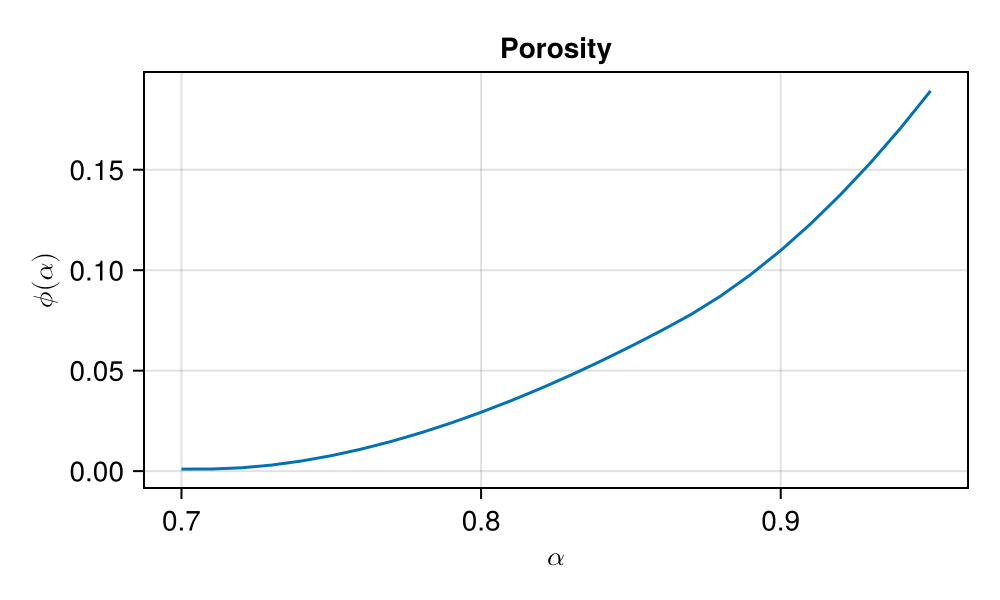

In [4]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [5]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [6]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

(wt_t0 = 3329.666114613028, cp_t0 = 4994.499171919542, wt_xMax = 90.3010033444816, cp_xMax = 153.51170568561872, lm_xMax = 199.66555183946488, wt_d0 = 0.06666666666666668, cp_d0 = 0.16993464052287582, lm_d0 = 1.0, xmax_peak_ratio = 1.5, xmax_mse = (0.6867626583840479, 1.5943063130159378), xmax_mse_half = (0.6867626583840479, 1.0604614581006935), alpha_mse = 0.0009549009427133483, cp_lprod_t0 = 3549.644056118994, wt_lprod_t0 = 2669.732290095131, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [7]:
# function get_lambda_half_v1(sol,t_range)
#     c0_t = [maximum(sol(t)[:,1]) for t in t_range] .- 1e-10

#     λhalf_id = [findall(sol(t)[:,1] .- 1e-10 .> 0.5*c0) for (t,c0) in zip(t_range,c0_t)]
#     λhalf_x = [length(id_list) != 0 ? tissue[maximum(id_list)] : 0. for id_list in λhalf_id];

#     λhalf_x, t_range[maximum(findall(x->x==maximum(λhalf_x),λhalf_x))]
# end

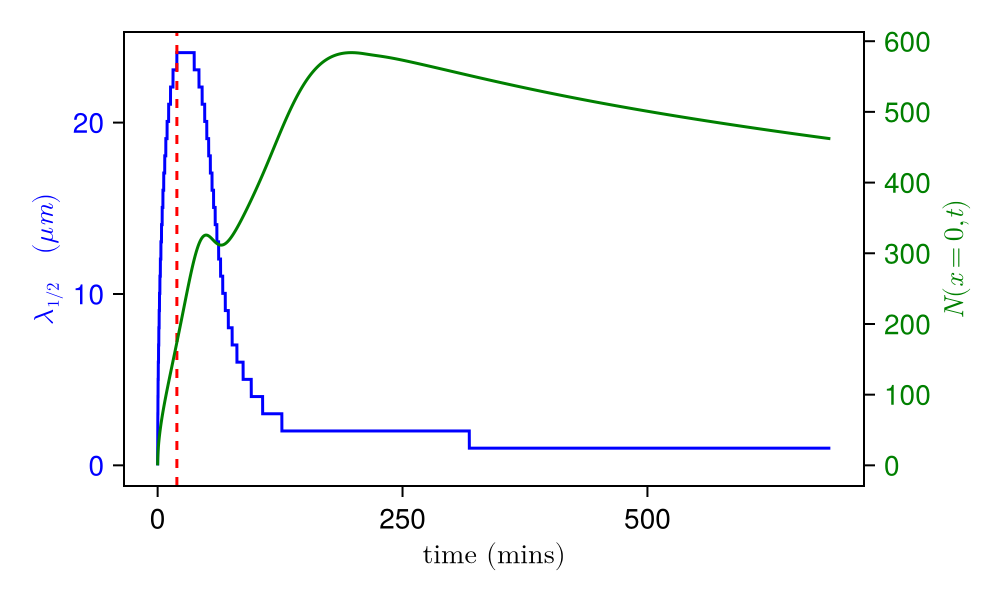

In [8]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_N)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

N_samp = 10000

λ_trange = LinRange(0.,sol.t[end],N_samp)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u),saveat = λ_trange);

N0t = [sol(t)[1,1] for t in λ_trange]

λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

c_max = maximum(sol(λhalf_max_t)[:,1])

lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

fig

In [9]:
# fig = Figure(size = (500,300))

# ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
# ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

# hidexdecorations!(ax_N)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

# N_samp = 10000

# λ_trange = LinRange(0.,sol.t[end],N_samp)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u),saveat = λ_trange);

# N0t = [sol(t)[1,1] for t in λ_trange]

# λhalf,λhalf_max_t = get_lambda_half_v1(sol,λ_trange)

# c_max = maximum(sol(λhalf_max_t)[:,1])

# lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

# lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

# vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

# save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT_v1.pdf"),fig)

# fig

In [37]:
data

Row,Time Point,SLB,WT
,Any,Any,Any
1,0,0,0
2,20,0,0
3,40,0,36.6857
4,60,61.937,49.9583
5,80,66.9755,46.9586
6,100,75.073,63.9966
7,120,72.444,42.393
8,140,86.598,41.139
9,160,83.8683,25.7758


In [35]:
alpha_data

Row,Position,0,30,60,90,120
,Any,Any,Any,Any,Any,Any
1,0,0.876589,0.850775,0.788455,0.778355,0.738766
2,30,0.887905,0.868624,0.826151,0.781019,0.759028
3,60,0.884151,0.870418,0.836597,0.809211,0.78209
4,90,0.883413,0.867566,0.85877,0.832959,0.79701
5,120,0.887139,0.864922,0.856426,0.851916,0.810655
6,150,0.88253,0.877825,0.868734,0.852062,0.837127
7,180,0.877836,0.867956,0.864263,0.863295,0.842331
8,210,0.863001,0.861421,0.85836,0.868665,0.855399
9,240,0.879227,0.863825,0.846108,0.876581,0.851658


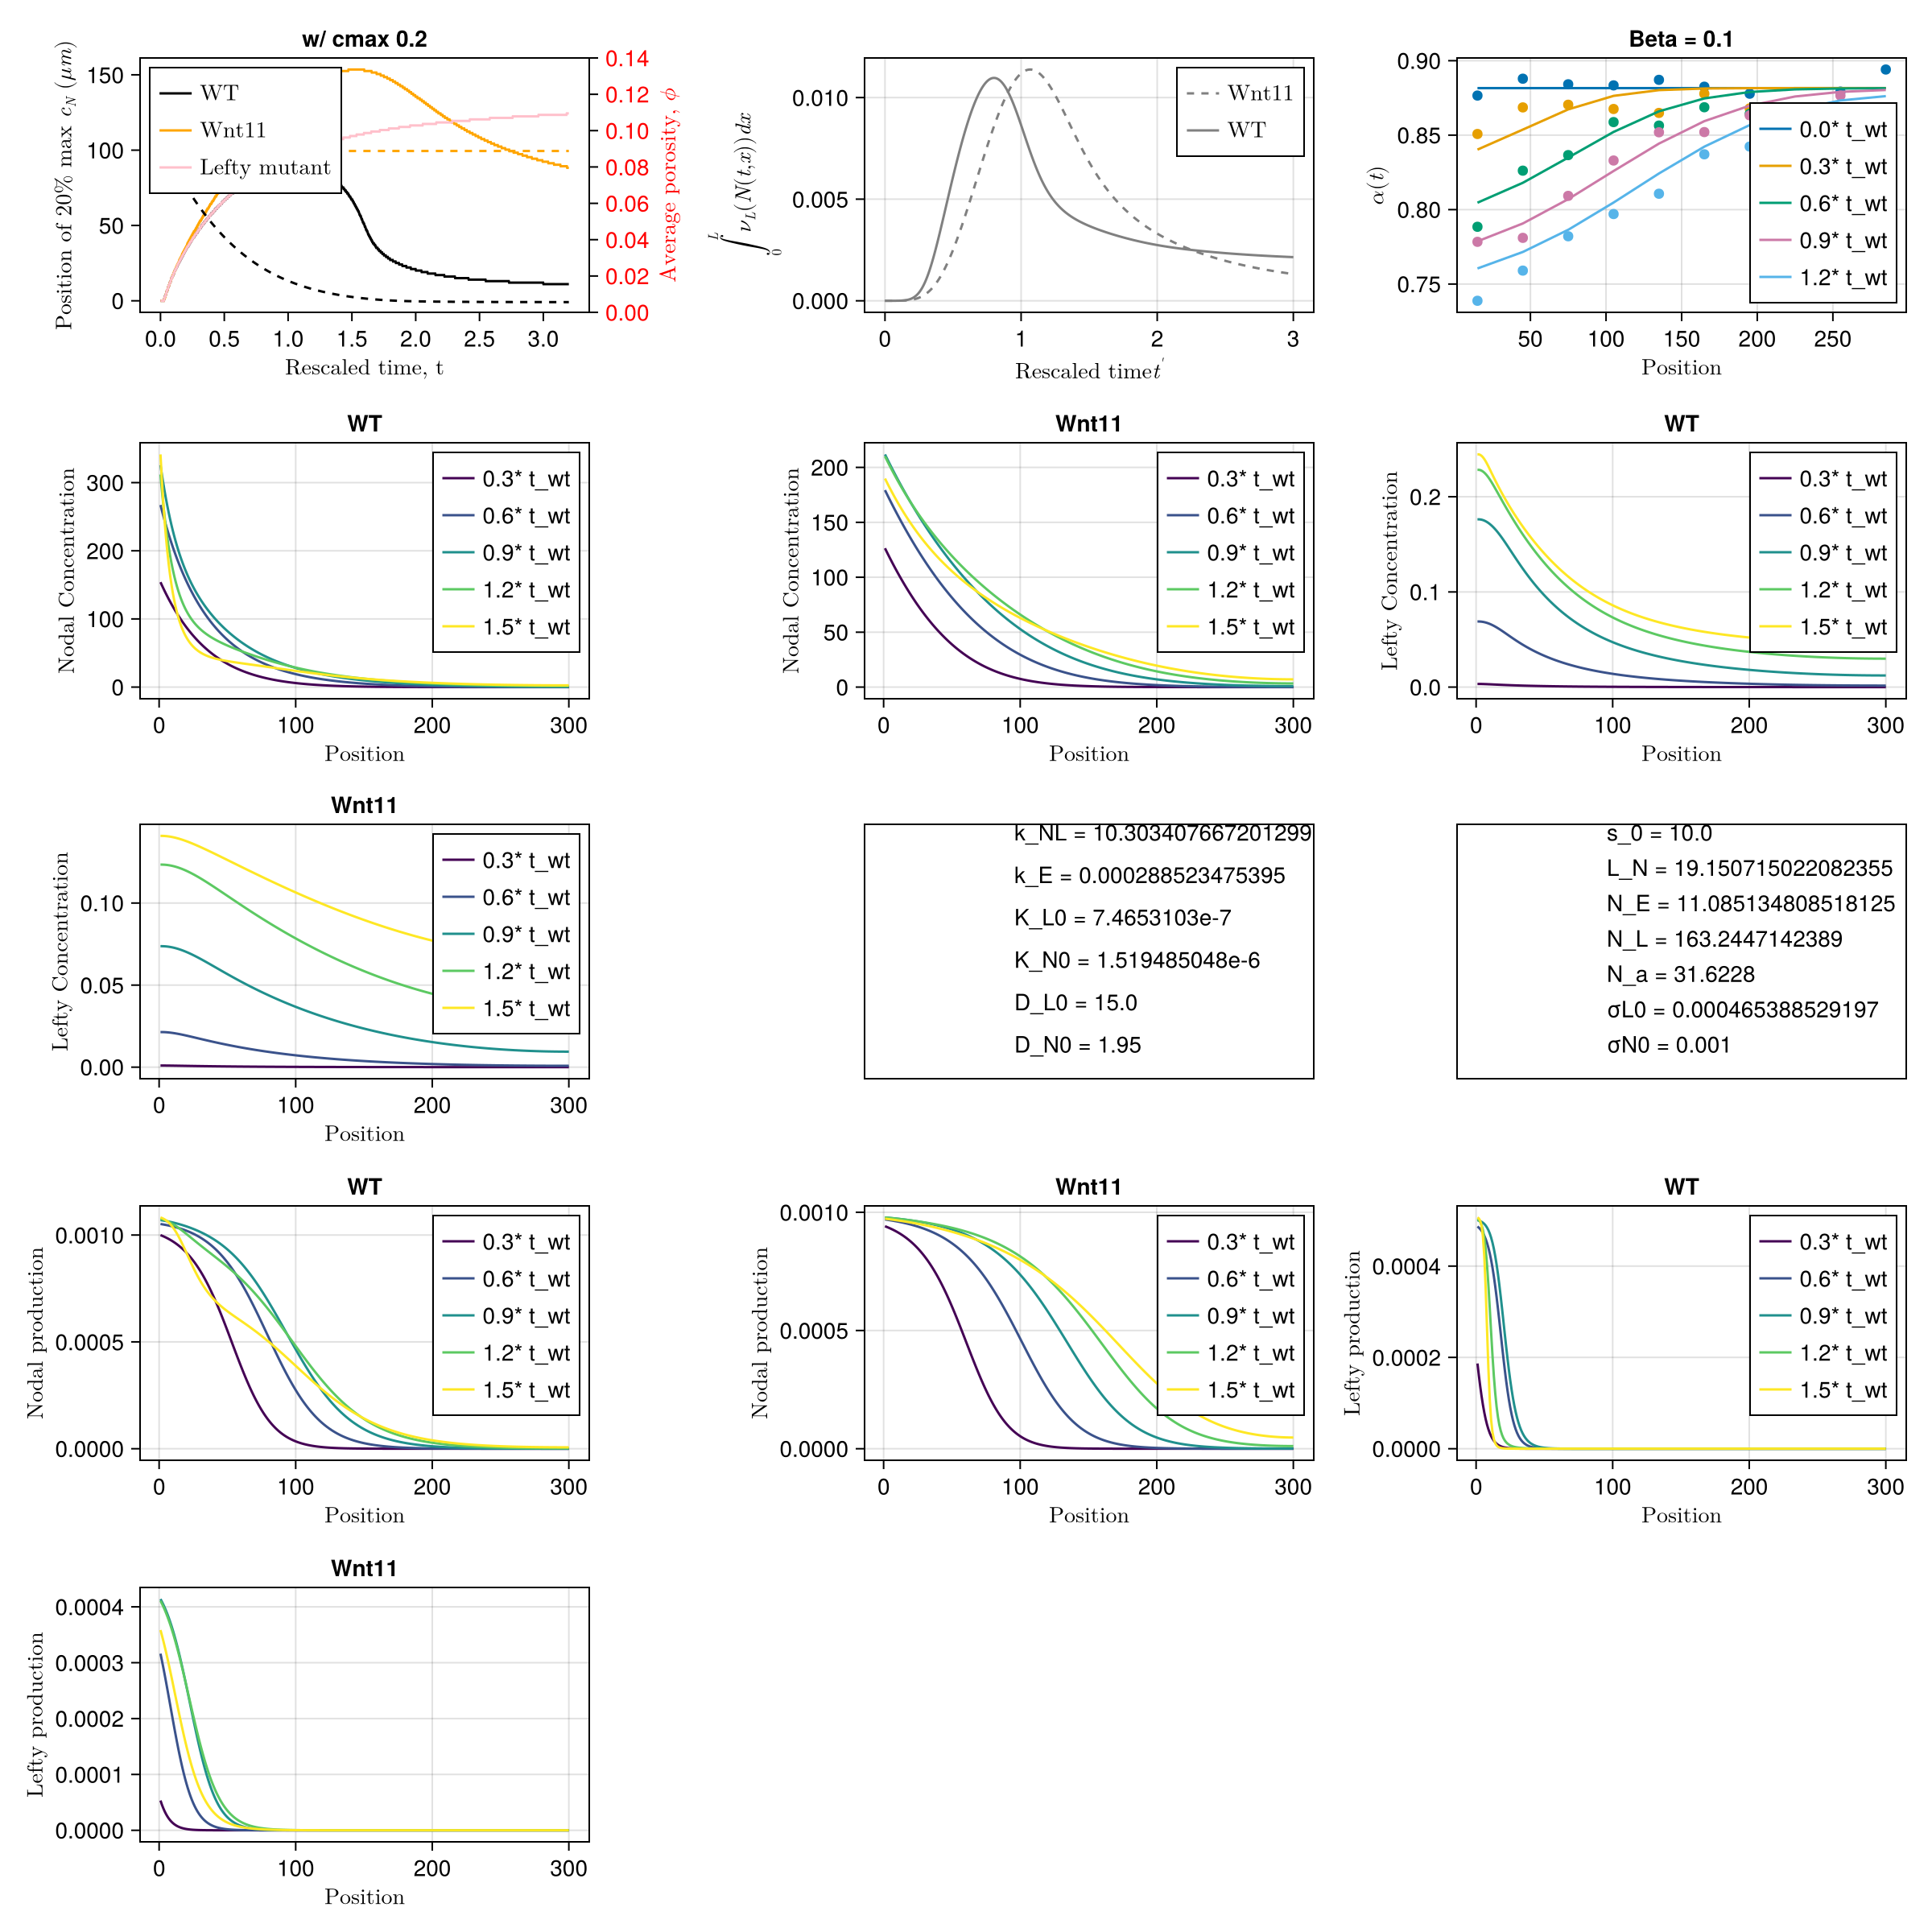

In [10]:
fig = Figure(size = (1200,1200))

# fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,0.8*Na,NL,0.5*NE,0.5*LN,s0],prob)

fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0],prob)

# save(plotsdir(exp_name * "/OrigFits/Summary.pdf"),fig)

fig

In [11]:
save(plotsdir(exp_name * "/OrigFits/Summary.pdf"),fig)

CairoMakie.Screen{PDF}


In [12]:
# pv = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0];

pv = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]

p_tuple,p_cp_tuple,p_lm_tuple = get_params(pv)

(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level,(sol,sol_cp,sol_lm) = get_alpha_xmax_lambda(pv,prob,0.2);


In [13]:
parameter_df =  DataFrames.DataFrame()

for var in p_names
    parameter_df[!,p_names_string[var]] = [p_tuple[var]]
end

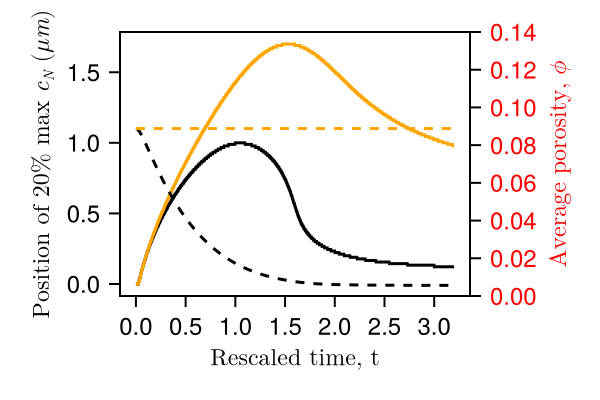

In [14]:
fig = Figure(size = (300,200), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false)
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

rs_wt_max = maximum(level_x_wt_rescaled)

lines!(ax,t_plot,level_x_wt_rescaled ./ rs_wt_max,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled ./ rs_wt_max,color = :orange,label = L"\text{Wnt11}")
# lines!(ax,t_plot,level_x_lm_rescaled,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# axislegend(ax,position = :lt)

ylims!(ax_por,0.,0.14)

ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

save(plotsdir(exp_name * "/FinalFigures/SMADPlots.pdf"),fig)

fig


In [15]:
smad_plot_df = DataFrames.DataFrame()

smad_plot_df[!,"Time"] = t_plot
smad_plot_df[!,"SMAD_curve_fits_WT"] = level_x_wt_rescaled
smad_plot_df[!,"SMAD_curve_fits_Wnt11"] = level_x_cp_rescaled
smad_plot_df[!,"porosity_WT"] = porosity_dyn
smad_plot_df[!,"porosity_Wnt11"] = porosity_dyn_cp;

In [16]:
orig_metrics = get_summary_metrics(pv,prob,data,alpha_data,0.2)

(wt_t0 = 3329.666114613028, cp_t0 = 4994.499171919542, wt_xMax = 90.3010033444816, cp_xMax = 153.51170568561872, lm_xMax = 199.66555183946488, wt_d0 = 0.06666666666666668, cp_d0 = 0.16993464052287582, lm_d0 = 1.0, xmax_peak_ratio = 1.5, xmax_mse = (0.6867626583840479, 1.5943063130159378), xmax_mse_half = (0.6867626583840479, 1.0604614581006935), alpha_mse = 0.0009549009427133483, cp_lprod_t0 = 3549.644056118994, wt_lprod_t0 = 2669.732290095131, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

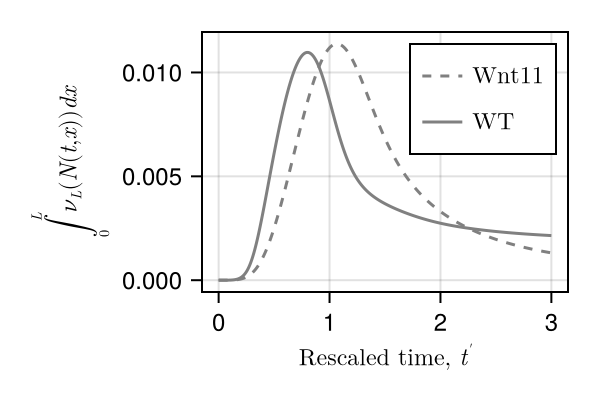

In [17]:
fig = Figure(size = (300,200), fontsize = 12.)

t_plot_int = LinRange(0,3*orig_metrics[:wt_t0],1000)

νN_int_cp,νN_int = get_integrated_lefty_prod_values(sol,sol_cp,t_plot_int,p_tuple,p_cp_tuple)

# nodal_prod_cp,nodal_prod = get_integrated_nodal_prod_values(sol,sol_cp,t_plot_int)

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, } t^{'}", ylabel= L"\int_0^L ν_L(N(t,x)) dx" )

lines!(ax,LinRange(0,3,1000),νN_int_cp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(ax,LinRange(0,3,1000),νN_int,color = :grey, label = L"\text{WT}")

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/FinalFigures/TotalLeftyProd.pdf"),fig)

fig


In [18]:
intl_plot_df = DataFrames.DataFrame()

intl_plot_df[!,"Time"] = LinRange(0,3,1000)
intl_plot_df[!,"total_lefty_prod_WT"] = νN_int
intl_plot_df[!,"total_lefty_prod_Wnt11"] = νN_int_cp;

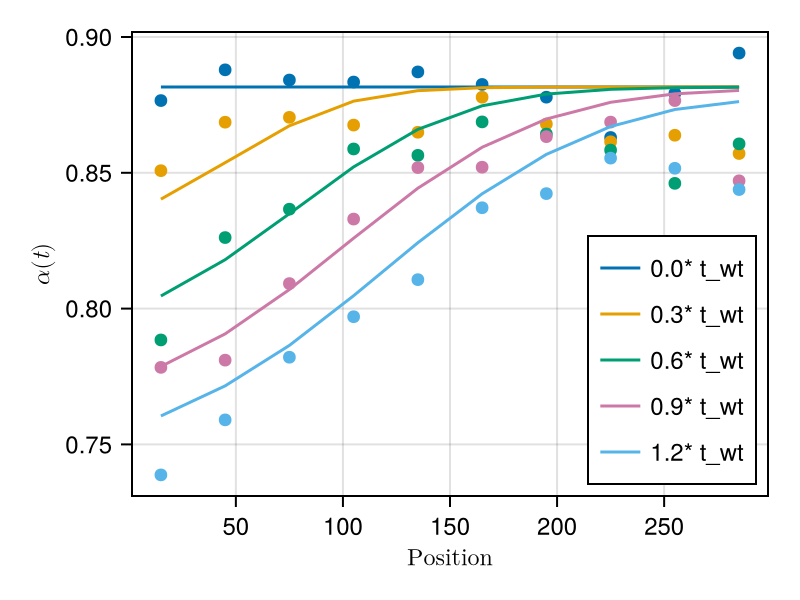

In [19]:
fig = Figure(size = (400,300), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)")

for (n,d) in enumerate(dyn_alpha[1:end-1])
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)


save(plotsdir(exp_name * "/FinalFigures/AlphaFits.pdf"),fig)

fig


In [20]:
alpha_fits  = DataFrames.DataFrame()

alpha_fits[!,"Position (um)"] = alpha_x

for (n,d) in enumerate(dyn_alpha[1:end-1])
    alpha_fits[!,string(alpha_data_times_norm[n])* "* t_wt"] = d
end

alpha_fits

Row,Position (um),0.0* t_wt,0.3* t_wt,0.6* t_wt,0.9* t_wt,1.2* t_wt
,Int64,Float64,Float64,Float64,Float64,Float64
1,15,0.881586,0.840293,0.804641,0.778693,0.760475
2,45,0.881586,0.853733,0.818005,0.790692,0.771553
3,75,0.881586,0.867304,0.834946,0.807027,0.786447
4,105,0.881586,0.876383,0.852169,0.825924,0.804749
5,135,0.881586,0.88024,0.865997,0.844337,0.824262
6,165,0.881586,0.881324,0.87467,0.859403,0.842269
7,195,0.881586,0.881546,0.878981,0.869816,0.85678
8,225,0.881586,0.881581,0.880735,0.875962,0.867042
9,255,0.881586,0.881586,0.881338,0.879074,0.873303


In [21]:
t_check = alpha_data_times_norm[2:end] .* orig_metrics[:wt_t0]

prob_finite = remake(prob,tspan = (0,alpha_data_times_norm[end] * orig_metrics[:wt_t0]))

sol_profiles = solve(prob_finite, p = p_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);
sol_profiles_cp = solve(prob_finite, p = p_cp_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);

dyn_N = [sol[:,1] for sol in sol_profiles.u[1:length(t_check)]]
dyn_L = [sol[:,2] for sol in sol_profiles.u[1:length(t_check)]];
dyn_α = [sol[:,4] for sol in sol_profiles.u[1:length(t_check)]];

bin_size = 15

dyn_N_binned = [[mean(N[n+1:n+bin_size]) for n in 0:bin_size:300-bin_size] for N in dyn_N]

dyn_N_cp = [sol[:,1] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_L_cp = [sol[:,2] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_α_cp = [sol[:,4] for sol in sol_profiles_cp.u[1:length(t_check)]];

dyn_N_cp_binned = [[mean(N[n+1:n+10]) for n in 0:10:290] for N in dyn_N_cp]

lefty_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σL0],ϕ0,ϕ.(α)),p_cp_tuple[:NL],p_cp_tuple[:mL]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
lefty_prod_profiles = [ν.(cN,σ.(p_tuple[:σL0],ϕ0,ϕ.(α)),p_tuple[:NL],p_tuple[:mL]) for (cN,α) in zip(dyn_N,dyn_α)];

nodal_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σN0],ϕ0,ϕ.(α)),p_cp_tuple[:Na],p_cp_tuple[:mN]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
nodal_prod_profiles = [ν.(cN,σ.(p_tuple[:σN0],ϕ0,ϕ.(α)),p_tuple[:Na],p_tuple[:mN]) for (cN,α) in zip(dyn_N,dyn_α)];

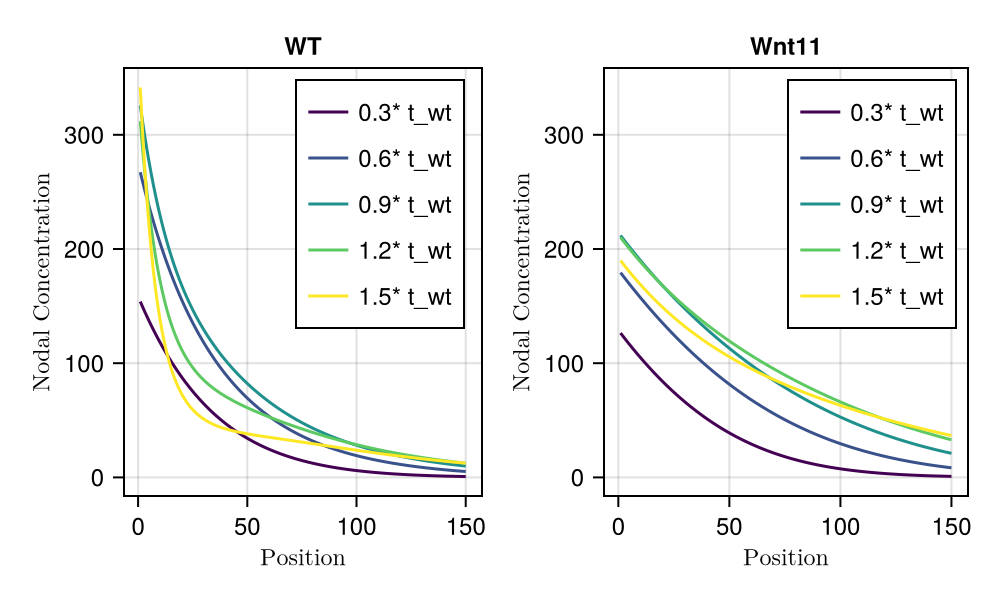

In [22]:
fig = Figure(size = (500,300), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}", title = "WT")

for (i,N) in enumerate(dyn_N)
    lines!(ax1,N[1:150],label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

axislegend(ax1,position = :rt)

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}", title = "Wnt11")

for (i,N) in enumerate(dyn_N_cp)
    lines!(ax2,N[1:150],label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

linkyaxes!(ax1,ax2)

save(plotsdir(exp_name * "/FinalFigures/NodalProfiles.pdf"),fig)

axislegend(ax2,position = :rt)

fig

In [23]:
nodal_profiles  = DataFrames.DataFrame()

nodal_profiles[!,"Position (um)"] = 1:1:300

for (i,N) in enumerate(dyn_N)
    nodal_profiles[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

nodal_profiles_cp  = DataFrames.DataFrame()

nodal_profiles_cp[!,"Position (um)"] = 1:1:300

for (i,N) in enumerate(dyn_N_cp)
    nodal_profiles_cp[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

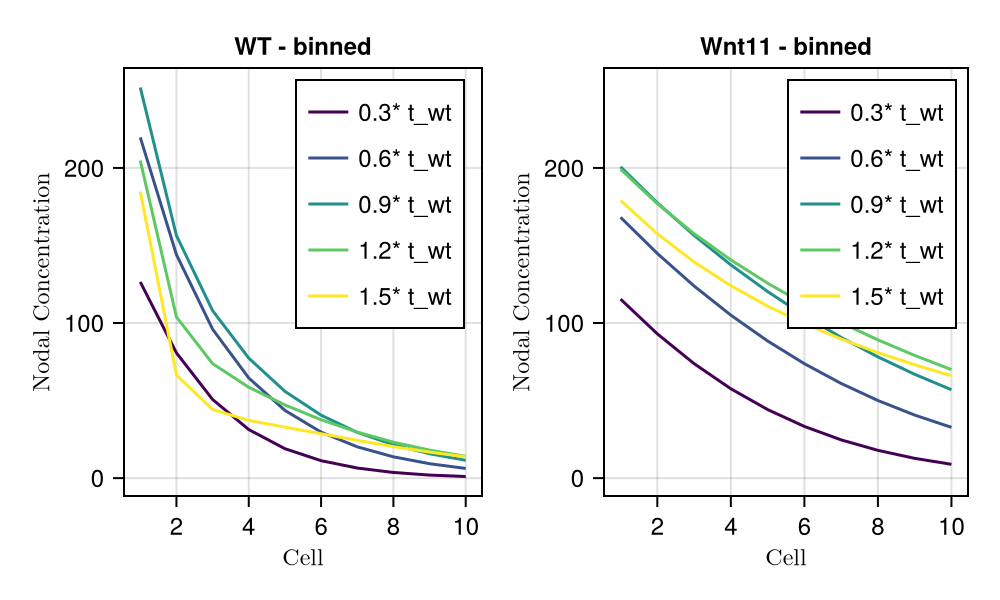

In [24]:
fig = Figure(size = (500,300), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Cell}", ylabel= L"\text{Nodal Concentration}", title = "WT - binned")

for (i,N) in enumerate(dyn_N_binned)
    lines!(ax1,N[1:10],label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

axislegend(ax1,position = :rt)

ax2 = Axis(fig[1,2], xlabel = L"\text{Cell}", ylabel= L"\text{Nodal Concentration}", title = "Wnt11 - binned")

for (i,N) in enumerate(dyn_N_cp_binned)
    lines!(ax2,N[1:10],label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

linkyaxes!(ax1,ax2)

axislegend(ax2,position = :rt)

save(plotsdir(exp_name * "/FinalFigures/NodalProfilesBinned.pdf"),fig)

fig

In [31]:
nodal_profiles_binned  = DataFrames.DataFrame()

nodal_profiles_binned[!,"Cell"] = 1:length(dyn_N_cp_binned[1])

for (i,N) in enumerate(dyn_N_binned)
    nodal_profiles_binned[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

nodal_profiles_binned_cp  = DataFrames.DataFrame()

nodal_profiles_binned_cp[!,"Cell"] = 1:length(dyn_N_cp_binned[1])

for (i,N) in enumerate(dyn_N_cp_binned)
    nodal_profiles_binned_cp[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

ArgumentError: ArgumentError: New columns must have the same length as old columns

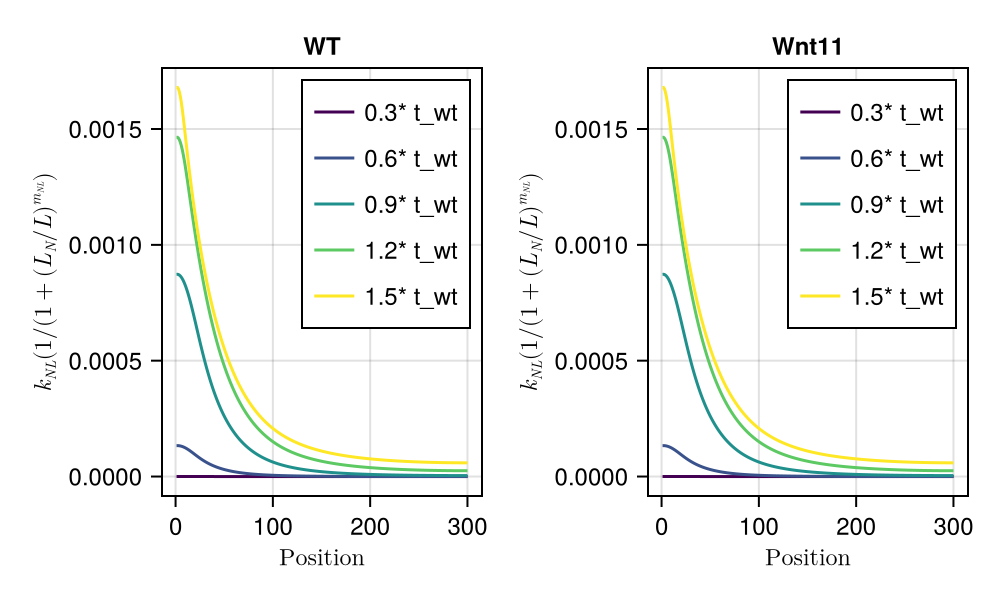

In [32]:
fig = Figure(size = (500,300), fontsize = 12.)

nodal_degr = [kNL.*(1 ./ (1 .+ (LN ./ L) .^ mNL)) for L in dyn_L]
nodal_degr_cp = [kNL.*(1 ./ (1 .+ (LN ./ L) .^ mNL)) for L in dyn_L]

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"k_{NL} (1 / (1 + (L_N / L)^{m_{NL}})", title = "WT")

for (i,N) in enumerate(nodal_degr)
    lines!(ax1,N,label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

axislegend(ax1,position = :rt)

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"k_{NL} (1 / (1 + (L_N / L)^{m_{NL}})", title = "Wnt11")

for (i,N) in enumerate(nodal_degr_cp)
    lines!(ax2,N,label = string(alpha_data_times_norm[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

axislegend(ax2,position = :rt)

save(plotsdir(exp_name * "/FinalFigures/LeftyInducedNodalDeg.pdf"),fig)

fig

In [33]:
nodal_deg_profiles  = DataFrames.DataFrame()

nodal_deg_profiles[!,"Position (um)"] = 1:1:300

for (i,N) in enumerate(nodal_degr)
    nodal_deg_profiles[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

nodal_deg_profiles_cp  = DataFrames.DataFrame()

nodal_deg_profiles_cp[!,"Position (um)"] = 1:1:300

for (i,N) in enumerate(nodal_degr_cp)
    nodal_deg_profiles_cp[!,string(alpha_data_times_norm[2:end][i]) * "* t_wt"] = N
end

In [34]:
# XLSX.writetable(exp_name *  "FigureData" * ".xlsx", "SMADFits"=>smad_plot_df,"TotalLeftyProduction"=>intl_plot_df,"AlphaFits"=>alpha_fits,"AlphaExpData"=>alpha_data,"NodalProfiles_WT"=>nodal_profiles,"NodalProfiles_Wnt11"=>nodal_profiles_cp,"NodalProfiles_WT_binned"=>nodal_profiles_binned,"NodalProfiles_Wnt11_binned"=>nodal_profiles_cp_binned);

XLSX.writetable(plotsdir(exp_name *  "/FinalFigures/FigureData" * ".xlsx"), "SMADFits"=>smad_plot_df,"TotalLeftyProduction"=>intl_plot_df,"AlphaFits"=>alpha_fits,"AlphaExpData"=>alpha_data,"NodalProfiles_WT"=>nodal_profiles,"NodalProfiles_Wnt11"=>nodal_profiles_cp,"LftyInducedDeg_WT"=>nodal_deg_profiles,"LftyInducedDeg_Wnt11"=>nodal_deg_profiles_cp);

AssertionError: AssertionError: /Users/boothh/Documents/TissueRigidity/plots/NodalLefty_DiffusionDominated_Optimal_v1/FinalFigures/FigureData.xlsx already exists.